# Playground

## Import packages

In [1]:
%reload_ext autoreload

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import simulator as sim

## Sensor and anomaly simulation

### Define values

In [2]:
nbr_series = 3  # nbr of time series
n_sim = 10000  # nbr of simulations
lag = 3  # lag for the ar-series
anomaly_amp = 10
anomaly_freq = 0.01
season_amp = 0  # amplitude of seasonal component
season_period = 1  # season period
e = 1

### Set AR-matrices

In [3]:
ar = np.zeros((nbr_series, nbr_series))
constant = np.zeros(nbr_series)
trend = np.zeros(nbr_series)

In [4]:
# first time series
ar[0, 0] = 0.5

constant[0] = 0
trend[0] = 0

In [5]:
# second time series
ar[0, 1] = 0.4
ar[1, 0] = 0
ar[1, 1] = 0.4

constant[1] = 0
trend[1] = 0

In [6]:
# third time series
ar[1, 2] = 0.5
ar[2, 0] = 0.1
ar[2, 1] = 0.1
ar[2, 2] = 0.1

constant[2] = 0
trend[2] = 0

### Simulate sensor data

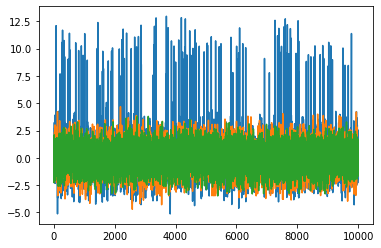

In [7]:
sensor = sim.sensor_simulation(n_sim, nbr_series, ar, lag, constant, trend, e,
                               season_amp, season_period)
time = np.linspace(0, n_sim - 1, n_sim)
sensor_df = pd.DataFrame(sensor, index=time)
anomaly_df = pd.DataFrame(index=time)
anomaly_df['Point anomaly'] = pd.Series(
    sim.point_anomaly(anomaly_freq, n_sim, anomaly_amp))
#anomaly_df['Trend anomaly'] = pd.Series(trend_anomaly(0.01, n_sim, 20, 3))

sensor_df[0] = sensor_df[0] + anomaly_df[
    'Point anomaly']  # add point anomalies to first time series
sensor_df.fillna('0')
plt.plot(sensor_df);

#### Alternative simulation

In [9]:
#empty = np.zeros((150,2))
#model = VARMAX(empty, order=(1, 0), trend='c')

# [trend, trend, ar11, ar12, ar22, ar21, sigma]
#simulations = model.simulate([1, A[0,0], 0, 0, 0.5, 0, 0.1], 150)

#empty = np.zeros(150)
#model = SARIMAX(empty, order=(1, 0, 0), trend='c')
#simulations = model.simulate([1, 0.9, 0.1], 150)
#plt.plot(simulations)

## Models

### Isolation Forest

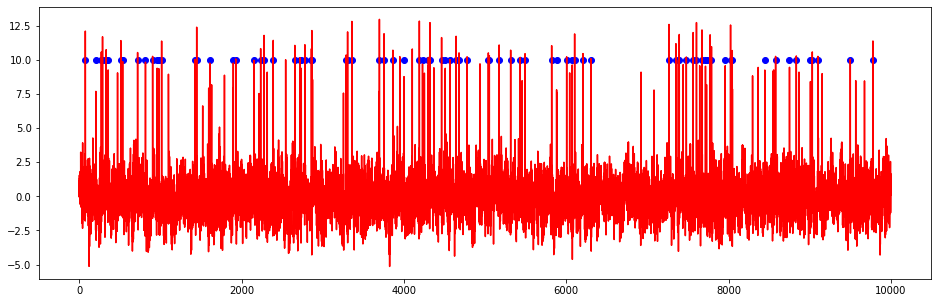

In [10]:
from sklearn.ensemble import IsolationForest
model = IsolationForest(n_estimators=100,
                        contamination=0.01,
                        max_samples='auto',
                        behaviour='new')

model.fit(sensor_df)
anomaly_df['Predicted anomaly'] = pd.Series(model.predict(sensor_df))
fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(sensor_df[0], color='red')

a = anomaly_df.loc[anomaly_df['Predicted anomaly'] == -1,
                   ['Point anomaly']]  #anomaly
ax.scatter(a.index, a['Point anomaly'], color='blue');

In [11]:
pred_anomaly_bool = anomaly_df['Predicted anomaly'] == -1
anomaly_bool = (anomaly_df['Point anomaly'] != 0)

In [12]:
confusion_matrix(pred_anomaly_bool, anomaly_bool)

array([[9865,   35],
       [  17,   83]])

In [13]:
precision_score(pred_anomaly_bool, anomaly_bool)

0.7033898305084746

In [14]:
recall_score(pred_anomaly_bool, anomaly_bool)

0.83